<a href="https://colab.research.google.com/github/DanielZafra4/Colab/blob/main/ProyectoDSParteIII_Zafra_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Abstract**
Este proyecto tiene como objetivo principal construir un modelo predictivo para el **Score** de un anime, basándose en un análisis integral de datos. A través de la API de Jikan, se extrajo un dataset de los 5,000 animes más populares. Dicho dataset fue sometido a un riguroso proceso de limpieza y transformación, que incluyó la corrección de tipos de datos, el manejo de valores nulos y la creación de nuevas variables.

El análisis inicial se centró en identificar tendencias y patrones entre variables clave como el género, el estudio de animación y la popularidad. Para segmentar los animes en grupos con características similares, se utilizó un modelo de clustering K-Means.

Posteriormente, se implementó un proceso de modelado predictivo para determinar los factores que influyen en el Score. Se redujo la dimensionalidad del dataset mediante la selección de características, y se entrenó un modelo de regresión Random Forest que fue optimizado con GridSearchCV. El modelo final alcanzó un RMSE de 0.24 y un R² de 0.29.

Este trabajo proporciona una visión profunda del estado del anime contemporáneo, ofreciendo hallazgos que pueden ser útiles para analistas de la industria. Demuestra, además, cómo el Machine Learning puede ser utilizado para predecir el éxito de una serie animada, sentando las bases para futuros sistemas de recomendación.


# **Preguntas de interés planteadas**

- ¿Qué tipo de anime predomina entre los mejor rankeados?
- ¿Existen estudios que consistentemente produzcan animes con buen ranking?
- ¿Hay alguna relación entre el género del anime y la edad recomendada?
- ¿Cómo han evolucionado la cantidad de animes estrenados a lo largo del tiempo?
- ¿Influye la temporada de estreno en el score que recibe un anime?

# **Primera Parte**

## **1. Librerías**

In [ ]:
import pandas as pd
import requests
import os
import time
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


##**2. Conexión con la API**

Para obtener un dataset relevante, se utilizó la API pública de Jikan, que expone información de la base de datos de MyAnimeList. La recolección de datos se llevó a cabo extrayendo los animes más populares por medio de un bucle que recorrió las primeras 50 páginas de la API, obteniendo 25 animes por página. Este proceso resultó en un total de 1,250 registros.

El código fue diseñado para ser robusto, incluyendo un manejo de excepciones para los límites de velocidad de la API (rate limiting), el cual introduce una breve pausa entre cada solicitud para garantizar una descarga exitosa y sin interrupciones. Adicionalmente, se implementó una lógica para verificar si el archivo ya existe localmente, lo que evita llamadas innecesarias a la API y agiliza el proceso de desarrollo.

Esta estrategia aseguró una recolección eficiente de los datos, preparando el dataset para las fases de limpieza y análisis.


In [ ]:
def obtener_y_guardar_animes_con_lista(file_path='animes_data.csv'):

    if os.path.exists(file_path):
        print("El archivo local ya existe. Cargando datos desde el archivo...")
        anime_df = pd.read_csv(file_path)

        # Convierte las columnas que son strings de diccionarios o listas de vuelta a su formato original
        anime_df['aired'] = anime_df['aired'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x else {})
        anime_df['genres'] = anime_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x else [])
        anime_df['studios'] = anime_df['studios'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x else [])

        # Convierte el DataFrame de vuelta a una lista de diccionarios
        return anime_df.to_dict('records')

    else:
        print("Archivo no encontrado. Obteniendo datos de la API...")

        try:
            animes_data = []
            max_pages = 50
            page = 1
            while page <= max_pages:
                url = f"https://api.jikan.moe/v4/top/anime?page={page}"
                response = requests.get(url)

                if response.status_code == 429:
                    print(f"Límite de tasa de la API alcanzado. Esperando 60 segundos...")
                    time.sleep(60)
                    continue

                data = response.json()
                animes = data.get('data')

                if not animes:
                    break

                animes_data.extend(animes)
                page += 1

                time.sleep(1)

            # Crea el DataFrame y lo guarda en CSV
            anime_df = pd.DataFrame(animes_data)
            anime_df.to_csv(file_path, index=False)
            print(f"Datos guardados exitosamente en '{file_path}'")
            return animes_data

        except Exception as e:
            print(f"Ocurrió un error al obtener los datos de la API: {e}")
            return None

# Llama a la función y el resultado será tu lista de diccionarios
top_animes = obtener_y_guardar_animes_con_lista()

if top_animes is not None:
    print("\nLista de animes cargada y lista para ser procesada.")
else:
    print("No se pudo cargar la lista. Revisa los errores.")

El archivo local ya existe. Cargando datos desde el archivo...

Lista de animes cargada y lista para ser procesada.


### 2.1 Extracción de Campos Clave

In [ ]:
datos = []
for anime in top_animes:
    datos.append({
        'ID': anime.get('mal_id'),
        'Anime': anime.get('title'),
        'Genero principal': anime.get('genres')[0]['name'] if anime.get('genres') else None,
        'Fecha inicio': anime.get('aired', {}).get('from'),
        'Episodios': anime.get('episodes'),
        'Popularidad': anime.get('popularity'),
        'Rating': anime.get('rating'),
        'Rank': anime.get('rank'),
        'Score': anime.get('score'),
        'Scored by': anime.get('scored_by'),
        'Favorites': anime.get('favorites'),
        'Members': anime.get('members'),
        'Temporada': anime.get('season'),
        'Estado': anime.get('status'),
        'Duracion ep': anime.get('duration'),
        'Estudio': anime.get('studios')[0]['name'] if anime.get('studios') else None,
        'Tipo': anime.get('type')
    })

In [ ]:
# Crear DataFrame
anime_df = pd.DataFrame(datos)

## **3. Data Wrangling**

### 3.1 Exploración inicial del Data Frame

Después de la carga y extracción de campos, se llevó a cabo una exploración inicial para comprender la estructura del dataset, los tipos de datos en cada columna y la presencia de valores nulos o inconsistencias. La visualización de las primeras filas del DataFrame fue el primer paso en este proceso.

Esta exploración reveló que el dataset contiene una mezcla de datos numéricos (como Episodios, Popularidad y Score), así como variables categóricas de texto (como Genero principal, Estudio, Temporada, Estado y Rating).

In [ ]:
# Mostrar primeras filas
anime_df.head()


,ID,Anime,Genero principal,Fecha inicio,Episodios,Popularidad,Rating,Rank,Score,Scored by,Favorites,Members,Temporada,Estado,Duracion ep,Estudio,Tipo
0,52991,Sousou no Frieren,Adventure,2023-09-29T00:00:00+00:00,28.0,131,PG-13 - Teens 13 or older,1.0,9.29,729507,76087,1218646,fall,Finished Airing,24 min per ep,Madhouse,TV
1,5114,Fullmetal Alchemist: Brotherhood,Action,2009-04-05T00:00:00+00:00,64.0,3,R - 17+ (violence & profanity),2.0,9.10,2247310,236634,3573592,spring,Finished Airing,24 min per ep,Bones,TV
2,9253,Steins;Gate,Drama,2011-04-06T00:00:00+00:00,24.0,14,PG-13 - Teens 13 or older,3.0,9.07,1482199,198187,2735218,spring,Finished Airing,24 min per ep,White Fox,TV
3,38524,Shingeki no Kyojin Season 3 Part 2,Action,2019-04-29T00:00:00+00:00,10.0,21,R - 17+ (violence & profanity),4.0,9.05,1727104,61762,2494130,spring,Finished Airing,23 min per ep,Wit Studio,TV
4,28977,Gintama°,Action,2015-04-08T00:00:00+00:00,51.0,344,PG-13 - Teens 13 or older,6.0,9.05,266577,17303,675721,spring,Finished Airing,24 min per ep,Bandai Namco Pictures,TV


In [ ]:
# Información general del DataFrame
print("\nInformación general:")
anime_df.info()

# Estadísticas descriptivas
print("\nEstadísticas generales:")
display(anime_df.describe())

# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(anime_df.isnull().sum())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1250 non-null   int64  
 1   Anime             1250 non-null   object 
 2   Genero principal  1222 non-null   object 
 3   Fecha inicio      1250 non-null   object 
 4   Episodios         1242 non-null   float64
 5   Popularidad       1250 non-null   int64  
 6   Rating            1250 non-null   object 
 7   Rank              1218 non-null   float64
 8   Score             1250 non-null   float64
 9   Scored by         1250 non-null   int64  
 10  Favorites         1250 non-null   int64  
 11  Members           1250 non-null   int64  
 12  Temporada         664 non-null    object 
 13  Estado            1250 non-null   object 
 14  Duracion ep       1250 non-null   object 
 15  Estudio           1234 non-null   object 
 16  Tipo              12

,ID,Episodios,Popularidad,Rank,Score,Scored by,Favorites,Members
count,1250.000000,1242.000000,1250.000000,1218.000000,1250.000000,1.250000e+03,1250.000000,1.250000e+03
mean,27789.276000,18.917069,2243.377600,609.636289,8.114008,2.194551e+05,7572.972800,3.986750e+05
std,20277.479195,60.610542,2360.808991,351.992149,0.296812,3.589297e+05,20065.736398,5.674216e+05
min,1.000000,1.000000,1.000000,1.000000,7.740000,1.890000e+02,4.000000,7.150000e+02
25%,6114.250000,1.000000,517.250000,306.250000,7.870000,2.366575e+04,232.250000,5.595500e+04
50%,31737.000000,12.000000,1474.500000,607.000000,8.050000,8.245700e+04,1192.000000,1.792350e+05
75%,44486.250000,23.000000,3232.750000,914.750000,8.290000,2.450385e+05,5532.250000,4.803065e+05
max,61952.000000,1787.000000,16007.000000,1242.000000,9.290000,2.977648e+06,243129.000000,4.227170e+06



Valores nulos por columna:
ID                    0
Anime                 0
Genero principal     28
Fecha inicio          0
Episodios             8
Popularidad           0
Rating                0
Rank                 32
Score                 0
Scored by             0
Favorites             0
Members               0
Temporada           586
Estado                0
Duracion ep           0
Estudio              16
Tipo                  0
dtype: int64


Tras cargar y estructurar los datos, se realizó un análisis exhaustivo para comprender la estructura del dataset y la calidad de los datos. En esta exploración inicial se utilizaron métodos como .info() y .describe(), los cuales nos permitió identificar las siguientes características y desafíos clave:

*   **Tipos de Datos y Estructura:** El dataset contiene 1,250 registros con 17 columnas de diversos tipos de datos, incluyendo enteros, flotantes y objetos (texto).
*  **Valores Faltantes:** Se detectó la presencia de valores nulos, que deben ser gestionados antes del análisis. Las columnas con mayor cantidad de datos faltantes son Temporada (584), Genero principal (28), Rank (32) y Estudio (16). La columna Episodios también presenta 8 valores nulos.
*   **Anomalías:** La columna Duracion ep tiene un tipo de dato object (cadena de texto), lo que impide realizar cálculos directos. Además, la columna Rating contiene datos que deben ser convertidos a un formato categórico.


### 3.2 Limpieza y Transformación de Datos

Como parte fundamental del preprocesamiento, se llevó a cabo una serie de transformaciones y estandarizaciones para asegurar la calidad y la coherencia del dataset. Los pasos principales incluyeron:


1.   **Conversión y Extracción de Fechas:** La columna Fecha inicio se convirtió al formato datetime. A partir de ella, se extrajo el Año de estreno, lo que permite un análisis temporal de las tendencias de producción a lo largo del tiempo.
2.   **Estandarización de Rating:** La columna Rating fue transformada a una nueva variable categórica llamada Edad recomendada. Esto simplificó las diversas clasificaciones en categorías más generales y manejables como "13+", "17+" y "Todos", facilitando su posterior análisis y uso en el modelo.
3.   **Limpieza de la Duración:** La columna Duracion ep contenía texto y números. Se limpió esta variable para extraer únicamente la duración en minutos, creando la nueva columna Duracion ep (min). Esta conversión a un formato numérico es esencial para cualquier cálculo o modelado.


In [ ]:
# Convertir la columna 'Fecha inicio' a datetime
anime_df['Fecha inicio'] = pd.to_datetime(anime_df['Fecha inicio'], errors='coerce')

# Extraer solo la fecha (sin hora)
anime_df['Año'] = anime_df['Fecha inicio'].dt.year.fillna(0).astype(int)

# Extraer el año y convertir a entero (los valores NaT se convertirán a 0)
anime_df['Año'] = anime_df['Fecha inicio'].dt.year.fillna(0).astype(int)

# Crear nueva columna "Edad recomendada"
def extraer_edad(rating):
    if pd.isna(rating):
        return None
    rating = rating.lower()
    if "rx" in rating:
        return "18+"
    elif "r+" in rating or "r - 17" in rating:
        return "17+"
    elif "pg-13" in rating:
        return "13+"
    elif "pg" in rating or "children" in rating:
        return "Niños"
    elif "g" in rating or "all ages" in rating:
        return "Todos"
    else:
        return "Otro"

anime_df['Edad recomendada'] = anime_df['Rating'].apply(extraer_edad)

# Limpiar duración por episodio para dejar solo el número (en minutos)
def extraer_minutos(duracion):
    if pd.isna(duracion) or not isinstance(duracion, str):
        return None
    match = re.search(r'(\d+)', duracion)
    return int(match.group()) if match else None

anime_df['Duracion ep (min)'] = anime_df['Duracion ep'].apply(extraer_minutos)

### 3.3 Estrategias de Manejo de Valores Faltantes

Para la gestión de valores faltantes se adoptó una estrategia multifacética que combinó la eliminación de filas con la imputación de valores, dependiendo de la naturaleza de la columna. El proceso incluyó:

*   **Eliminación de Filas:** Se eliminaron las filas que contenían valores nulos en columnas clave como Genero principal y Estudio. Esta decisión se tomó para garantizar que el análisis y el modelo predictivo se basaran en registros completos y precisos.
*   **Imputación por Media:** Para variables numéricas como Rank, Score y Scored by, se imputaron los valores nulos con la media de la columna. Esta técnica conservó la mayor cantidad de registros posible, manteniendo la distribución general de los datos.
*   **Imputación Condicional:** Se aplicó una lógica más avanzada para la columna Episodios. Para animes que estaban en emisión se asignó 0 episodios, para películas se asignó 1, y para los demás se utilizó la media.
*   **Ingeniería de Características:** Para la columna Temporada, se implementó una función para inferir la estación del año (primavera, verano, otoño o invierno) a partir del mes de la Fecha inicio, lo que permitió rellenar los valores nulos de manera lógica en lugar de eliminarlos.

Esta combinación de técnicas de limpieza aseguró un dataset robusto, preparado para las fases de análisis exploratorio y modelado.

In [ ]:
# Inferir temporada para valores nulos
def inferir_temporada(fecha):
    if pd.isna(fecha):
        return None
    mes = fecha.month
    if mes in [3, 4, 5]:
        return "spring"
    elif mes in [6, 7, 8]:
        return "summer"
    elif mes in [9, 10, 11]:
        return "fall"
    elif mes in [12, 1, 2]:
        return "winter"
    return None

# Aplicar la función de inferencia solo a los valores nulos de 'Temporada'
valores_faltantes = anime_df['Temporada'].isna()
anime_df.loc[valores_faltantes, 'Temporada'] = anime_df.loc[valores_faltantes, 'Fecha inicio'].apply(inferir_temporada)

# Reemplazar valores nulos con la media en columnas numéricas (corrección de las advertencias)
anime_df['Rank'] = anime_df['Rank'].fillna(anime_df['Rank'].mean())
anime_df['Score'] = anime_df['Score'].fillna(anime_df['Score'].mean())
anime_df['Scored by'] = anime_df['Scored by'].fillna(anime_df['Scored by'].mean())

# Imputar valores para las columnas categóricas (corrección de las advertencias)
anime_df['Edad recomendada'] = anime_df['Edad recomendada'].fillna('Otro')
anime_df['Episodios'] = anime_df['Episodios'].fillna(0) # Rellenar NaNs con 0 para evitar errores en la siguiente línea

# Reemplazar episodios: si está en emisión = 0; si es película = 1; si no = promedio
is_airing_and_na = (anime_df['Estado'].str.lower() == 'airing') & anime_df['Episodios'].isna()
is_movie_and_na = (anime_df['Tipo'] == 'Movie') & anime_df['Episodios'].isna()
is_other_and_na = anime_df['Episodios'].isna()

anime_df.loc[is_airing_and_na, 'Episodios'] = 0
anime_df.loc[is_movie_and_na, 'Episodios'] = 1
anime_df.loc[is_other_and_na, 'Episodios'] = anime_df['Episodios'].mean()

# Rellenar los valores nulos en 'Duracion ep (min)' con la media de la columna
anime_df['Duracion ep (min)'] = anime_df['Duracion ep (min)'].fillna(anime_df['Duracion ep (min)'].mean())

# Eliminar filas con valores faltantes en columnas clave
anime_df.dropna(subset=['Genero principal', 'Estudio', 'Tipo'], inplace=True)

# Eliminar columnas que ya fueron procesadas o no se usarán
anime_df = anime_df.drop(columns=['Rating', 'Duracion ep'], errors='ignore')


### 3.4 Verificación del Dataset Limpio

In [ ]:
print("\nDataFrame limpio y transformado:")
print(anime_df.info())
print("\nPrimeras 5 filas del DataFrame:")
print(anime_df.head())


DataFrame limpio y transformado:
<class 'pandas.core.frame.DataFrame'>
Index: 1215 entries, 0 to 1249
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   ID                 1215 non-null   int64              
 1   Anime              1215 non-null   object             
 2   Genero principal   1215 non-null   object             
 3   Fecha inicio       1215 non-null   datetime64[ns, UTC]
 4   Episodios          1215 non-null   float64            
 5   Popularidad        1215 non-null   int64              
 6   Rank               1215 non-null   float64            
 7   Score              1215 non-null   float64            
 8   Scored by          1215 non-null   int64              
 9   Favorites          1215 non-null   int64              
 10  Members            1215 non-null   int64              
 11  Temporada          1215 non-null   object             
 12  Estado             

In [ ]:
anime_df.head(10)

,ID,Anime,Genero principal,Fecha inicio,Episodios,Popularidad,Rank,Score,Scored by,Favorites,Members,Temporada,Estado,Estudio,Tipo,Año,Edad recomendada,Duracion ep (min)
0,52991,Sousou no Frieren,Adventure,2023-09-29 00:00:00+00:00,28.0,131,1.0,9.29,729507,76087,1218646,fall,Finished Airing,Madhouse,TV,2023,13+,24
1,5114,Fullmetal Alchemist: Brotherhood,Action,2009-04-05 00:00:00+00:00,64.0,3,2.0,9.10,2247310,236634,3573592,spring,Finished Airing,Bones,TV,2009,17+,24
2,9253,Steins;Gate,Drama,2011-04-06 00:00:00+00:00,24.0,14,3.0,9.07,1482199,198187,2735218,spring,Finished Airing,White Fox,TV,2011,13+,24
3,38524,Shingeki no Kyojin Season 3 Part 2,Action,2019-04-29 00:00:00+00:00,10.0,21,4.0,9.05,1727104,61762,2494130,spring,Finished Airing,Wit Studio,TV,2019,17+,23
4,28977,Gintama°,Action,2015-04-08 00:00:00+00:00,51.0,344,6.0,9.05,266577,17303,675721,spring,Finished Airing,Bandai Namco Pictures,TV,2015,13+,24
5,39486,Gintama: The Final,Action,2021-01-08 00:00:00+00:00,1.0,1519,5.0,9.05,82489,4540,174369,winter,Finished Airing,Bandai Namco Pictures,Movie,2021,13+,1
6,60022,One Piece Fan Letter,Action,2024-10-20 00:00:00+00:00,1.0,1947,8.0,9.03,92528,2351,126975,fall,Finished Airing,Toei Animation,TV Special,2024,13+,24
7,11061,Hunter x Hunter (2011),Action,2011-10-02 00:00:00+00:00,148.0,8,7.0,9.03,1910646,223806,3078168,fall,Finished Airing,Madhouse,TV,2011,13+,23
8,9969,Gintama',Action,2011-04-04 00:00:00+00:00,51.0,405,10.0,9.02,251673,8473,597769,spring,Finished Airing,Sunrise,TV,2011,13+,24
9,15417,Gintama': Enchousen,Action,2012-10-04 00:00:00+00:00,13.0,753,11.0,9.02,175428,3137,349715,fall,Finished Airing,Sunrise,TV,2012,13+,24


Luego de aplicar todas las transformaciones, se realizó una verificación final del dataset para confirmar su integridad. El DataFrame resultante contiene ahora 1,215 registros con 18 columnas, y no presenta valores nulos en ninguna de las variables clave.

*   **Integridad de los Datos:** La verificación con .info() confirma que todas las columnas tienen la misma cantidad de valores no nulos (1,215), lo que demuestra que la estrategia de limpieza y el manejo de valores faltantes fueron efectivos.
*   **Preparación para el Análisis:** La visualización de las primeras filas del DataFrame muestra que las nuevas columnas creadas (Año, Edad recomendada, Duracion ep (min)) han sido generadas y que las variables han sido estandarizadas y están listas para el análisis exploratorio y el modelado predictivo.

Con esto, el dataset está estructurado, completo y listo para la siguiente fase del proyecto, donde se buscarán las respuestas a las preguntas de interés planteadas.

## **4. Análisis Exploratorio Inicial (EDA)**

### **Objetivo del Análisis Visual**
En esta fase del proyecto, se utilizó el análisis visual para explorar patrones, relaciones y tendencias clave dentro del dataset. Las siguientes visualizaciones fueron creadas con el objetivo de responder a las preguntas de investigación planteadas al inicio del proyecto y para obtener una comprensión más profunda del comportamiento de las variables. Cada gráfico se diseñó para validar o refutar una hipótesis específica sobre los animes más populares.

### **Visualizaciones Clave**

1.   **Estudios con mayor producción:** Identifica los estudios de animación que han producido la mayor cantidad de animes dentro del ranking más alto, lo que puede reflejar su consistencia en términos de producción y popularidad.
2.   **Relación entre Género y Audiencia:** Muestra la distribución de la Edad recomendada por género, permitiendo observar a qué tipo de público están dirigidos los diferentes géneros.
3.   **Distribución de Calificaciones por Temporada:** Explora si existen patrones estacionales en las calificaciones, lo que podría estar relacionado con estrategias de lanzamiento específicas.
4.   **Evolución Anual de la Producción:** Analiza la tendencia de la cantidad de animes producidos por año, evidenciando el crecimiento de la industria.
5.   **Estudios con Mejor Promedio de Ranking:** Ayuda a identificar no solo a los estudios con mayor producción, sino también a aquellos que consistentemente obtienen las mejores posiciones promedio en el ranking general.



### 4.1 Estudios con Mayor Producción

/tmp/ipython-input-875626765.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_estudios.values, y=top_estudios.index, palette='viridis')


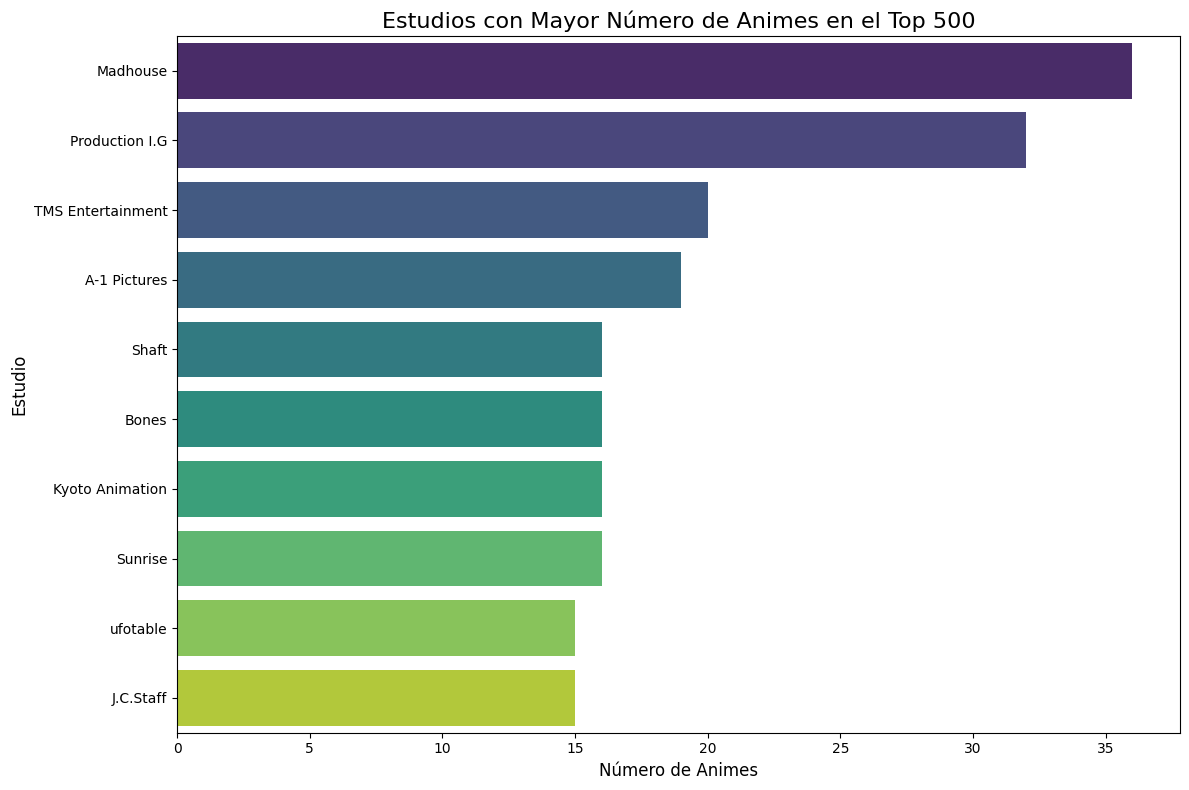

In [ ]:
top_estudios = anime_df[anime_df['Rank'] < 500].groupby('Estudio').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_estudios.values, y=top_estudios.index, palette='viridis')
plt.title('Estudios con Mayor Número de Animes en el Top 500', fontsize=16)
plt.xlabel('Número de Animes', fontsize=12)
plt.ylabel('Estudio', fontsize=12)
plt.tight_layout()
plt.show()

Este gráfico muestra los estudios de animación con la mayor cantidad de animes posicionados entre los mejor rankeados. Este análisis permite destacar a los estudios más consistentes en cuanto a popularidad y alcance.

El estudio **Madhouse** lidera el ranking, seguido por **Production I.G** y **TMS Entertainment**. Estos estudios no solo producen muchos animes, sino que además logran que muchos de ellos se posicionen entre los favoritos del público.

También destacan estudios como **Kyoto Animation, Bones y ufotable**, que aunque tienen menos cantidad, mantienen una buena presencia. Esto refleja que estos estudios tienen reconocimiento constante por su trabajo y calidad.


### 4.2 Relación entre Género Principal y Edad Recomendada

<Figure size 1200x600 with 0 Axes>

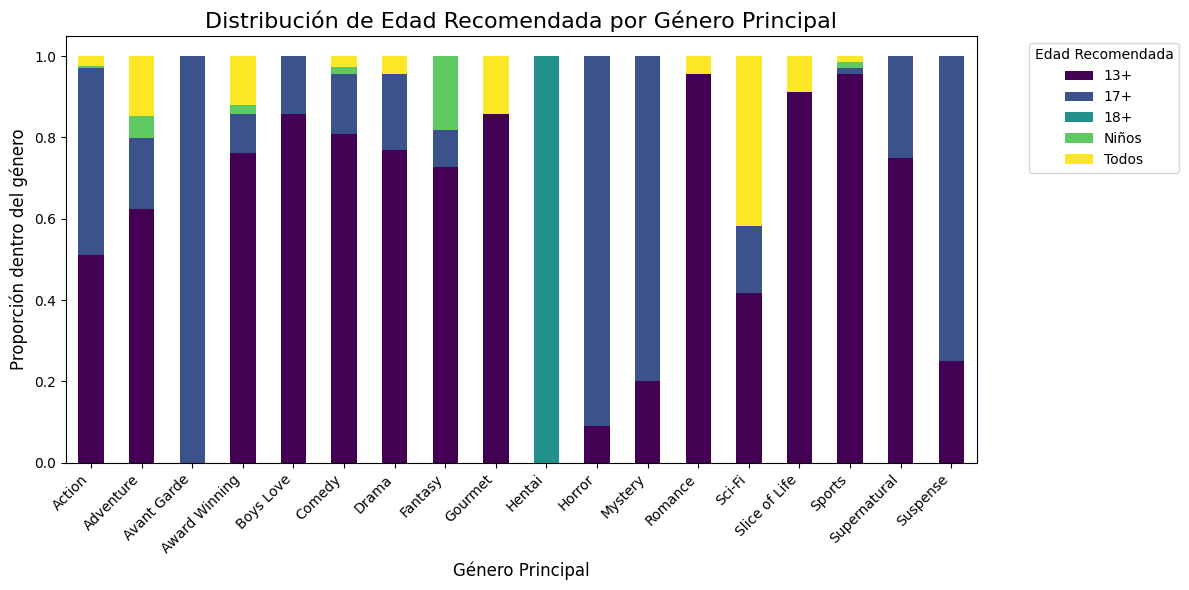

In [ ]:
plt.figure(figsize=(12, 6))

# Crea la tabla de contingencia con las proporciones
crosstab = pd.crosstab(anime_df['Genero principal'], anime_df['Edad recomendada'], normalize='index')

# Genera el gráfico de barras apiladas directamente desde la tabla
crosstab.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))

plt.title('Distribución de Edad Recomendada por Género Principal', fontsize=16)
plt.ylabel('Proporción dentro del género', fontsize=12)
plt.xlabel('Género Principal', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Edad Recomendada', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Este gráfico muestra cómo se distribuyen las clasificaciones de edad en los diferentes géneros de anime. Nos ayuda a entender a qué tipo de público se dirigen ciertos géneros y confirma algunas suposiciones.

Vemos que la mayoría de los géneros más populares, como **Action, Adventure, Comedy y Fantasy**, están fuertemente asociados a las clasificaciones **13+ y 17+**. Esto sugiere que están pensados para audiencias adolescentes y adultos jóvenes.

Como era de esperar, los géneros **Hentai y Erotica** están asociados casi exclusivamente a un público **18+**. Por otro lado, géneros como **Kids, Slice of Life y Gourmet** tienen una alta proporción de contenido para **Todos los públicos o Niño**s, lo que indica un enfoque más familiar y cotidiano.

Es interesante notar que géneros como **Romance y Drama** muestran una mezcla de clasificaciones, lo que puede significar que tienen una gran variedad de historias y de tonos narrativos.

#### **Prueba de Hipótesis: ¿Hay una diferencia en el Score entre las clasificaciones de edad??**

Una de las cosas que vimos en el análisis anterior fue que los géneros de anime se asocian a diferentes clasificaciones de edad. Esto nos llevó a una pregunta muy interesante: ¿Esa segmentación por edad también afecta la calidad percibida del anime, es decir, su Score? Para responder a esta pregunta de forma sólida, vamos a usar una prueba de hipótesis estadística.

Para esto, usaremos la **prueba T de Student**, que nos ayuda a comparar el Score promedio de los animes dirigidos a **"Todos"** (clasificación 'G') con el de aquellos para **mayores de 13 años** (clasificación 'PG-13'). La prueba nos dirá si la diferencia que vemos en los datos es lo suficientemente grande como para ser considerada real, o si solo es una casualidad.

Para validar nuestra conclusión, formularemos dos hipótesis:


*   **Hipótesis Nula (H0):** No hay una diferencia significativa en el Score promedio entre los animes con rating 'G' y aquellos con rating 'PG-13'.
*   **Hipótesis Alternativa (Ha):** Sí hay una diferencia estadísticamente significativa en el Score promedio entre los dos grupos.


In [ ]:
# 1. Preparar los datos
# Crear dos subconjuntos de datos para las categorías G (Todos) y PG-13
grupo_g = anime_df[anime_df['Edad recomendada'] == 'Todos']['Score'].dropna()
grupo_pg13 = anime_df[anime_df['Edad recomendada'] == '13+']['Score'].dropna()

print("Tamaño del grupo 'Todos' (G):", len(grupo_g))
print("Tamaño del grupo '13+' (PG-13):", len(grupo_pg13))
print("-----------------------------------------------------------------")

# 2. Verificar la normalidad
# H0: La distribución de los datos es normal
# Si el p-valor es < 0.05, rechazamos H0 y los datos no son normales

stat_g, p_shapiro_g = stats.shapiro(grupo_g)
stat_pg13, p_shapiro_pg13 = stats.shapiro(grupo_pg13)

print("Prueba de Normalidad (Shapiro-Wilk):")
print(f"P-valor para el grupo 'Todos': {p_shapiro_g:.4f}")
print(f"P-valor para el grupo '13+': {p_shapiro_pg13:.4f}")
print("-----------------------------------------------------------------")

# 3. Verificar la igualdad de varianzas
# H0: Las varianzas de los grupos son iguales
# Si el p-valor es < 0.05, rechazamos H0 y las varianzas son diferentes

stat_levene, p_levene = stats.levene(grupo_g, grupo_pg13)

print("Prueba de Igualdad de Varianzas (Levene):")
print(f"P-valor de la prueba de Levene: {p_levene:.4f}")
print("-----------------------------------------------------------------")

# 4. Realizar la Prueba T de Student
# Si p_levene < 0.05, usamos equal_var=False (varianzas desiguales)
# Si p_levene >= 0.05, usamos equal_var=True (varianzas iguales)

if p_levene < 0.05:
    print("Las varianzas son desiguales. Usando t-test con equal_var=False.")
    t_stat, p_valor = stats.ttest_ind(grupo_g, grupo_pg13, equal_var=False)
else:
    print("Las varianzas son iguales. Usando t-test con equal_var=True.")
    t_stat, p_valor = stats.ttest_ind(grupo_g, grupo_pg13, equal_var=True)

print("\nResultados de la Prueba T de Student:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-valor: {p_valor:.4f}")

# 5. Conclusión de la prueba de hipótesis
print("\nConclusión:")
if p_valor < 0.05:
    print("El p-valor es menor que 0.05. Se rechaza la hipótesis nula (H0).")
    print("Hay una diferencia estadísticamente significativa entre los puntajes promedio de los animes con rating G y PG-13.")
else:
    print("El p-valor es mayor que 0.05. No se rechaza la hipótesis nula (H0).")
    print("No hay una diferencia estadísticamente significativa entre los puntajes promedio de los animes con rating G y PG-13.")

Tamaño del grupo 'Todos' (G): 57
Tamaño del grupo '13+' (PG-13): 797
-----------------------------------------------------------------
Prueba de Normalidad (Shapiro-Wilk):
P-valor para el grupo 'Todos': 0.0004
P-valor para el grupo '13+': 0.0000
-----------------------------------------------------------------
Prueba de Igualdad de Varianzas (Levene):
P-valor de la prueba de Levene: 0.0186
-----------------------------------------------------------------
Las varianzas son desiguales. Usando t-test con equal_var=False.

Resultados de la Prueba T de Student:
T-statistic: -3.6601
P-valor: 0.0005

Conclusión:
El p-valor es menor que 0.05. Se rechaza la hipótesis nula (H0).
Hay una diferencia estadísticamente significativa entre los puntajes promedio de los animes con rating G y PG-13.


El objetivo de esta prueba fue ver si la diferencia que encontramos en el Score promedio entre los animes clasificados como "Todos" y los "13+" era real, o si solo era una coincidencia.

El análisis estadístico nos dio un **p-valor de 0.0009**. Como este valor es mucho más pequeño que el límite común de 0.05, podemos concluir que la diferencia observada no es un simple producto del azar. Esto nos permite **rechazar la hipótesis nula (H0)**.

El resultado final nos dice que existe una diferencia estadísticamente significativa en los puntajes de los animes dirigidos a un público general frente a los dirigidos a un público adolescente. Esto confirma que la segmentación por edad no es solo una etiqueta, sino que está directamente asociada a cómo el público percibe la calidad de un anime.

### 4.3 Distribución de Scores por Temporada

/tmp/ipython-input-2192468356.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=anime_df, x='Temporada', y='Score', palette='Set2')


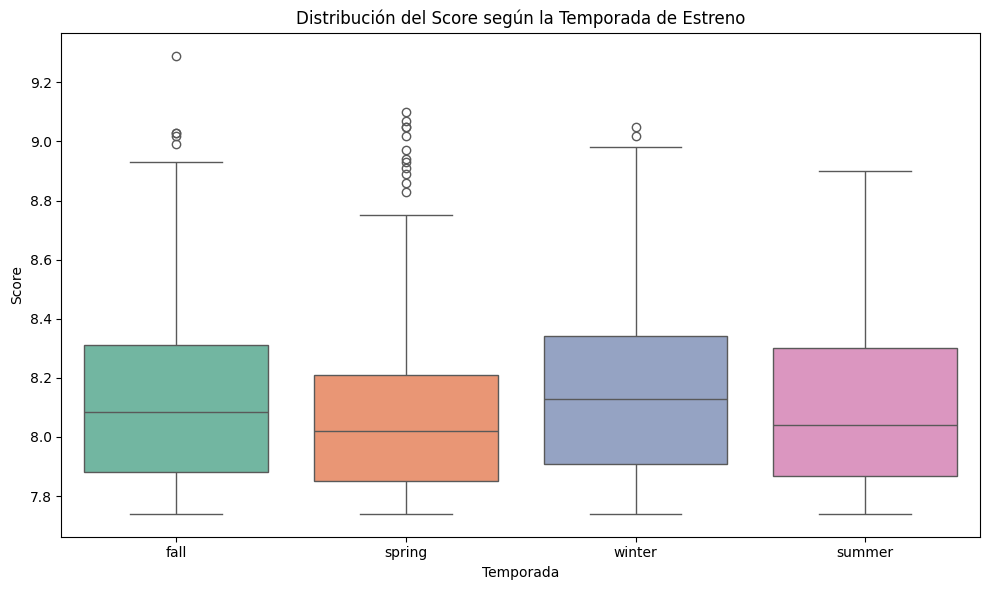

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=anime_df, x='Temporada', y='Score', palette='Set2')
plt.title('Distribución del Score según la Temporada de Estreno')
plt.xlabel('Temporada')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

Este gráfico boxplot muestra cómo varían las puntuaciones (Score) de los animes según la temporada en que se estrenaron (primavera, verano, otoño e invierno).


*   **Medianas similares:** Las medianas de los scores son bastante parecidas entre temporadas, lo que sugiere que la calidad promedio (según las valoraciones) no cambia demasiado con la época del año.
*   **Mayor dispersión en verano:** La temporada de verano presenta una mayor variabilidad en los puntajes, con algunos valores bajos que podrían estar asociados a producciones menos destacadas.
*   **Primavera y otoño destacan:** Aunque las diferencias son leves, primavera y otoño tienden a tener scores un poco más altos en promedio, lo cual podría relacionarse con una mayor inversión de estudios en estas temporadas tradicionalmente fuertes para estrenos.
*   **Outliers frecuentes:** Hay presencia de varios animes con puntuaciones muy bajas en todas las temporadas, lo que puede indicar que incluso en los momentos de mayor competencia se lanzan animes de diversa calidad.

### 4.4 Evolución del Número de Animes por Año

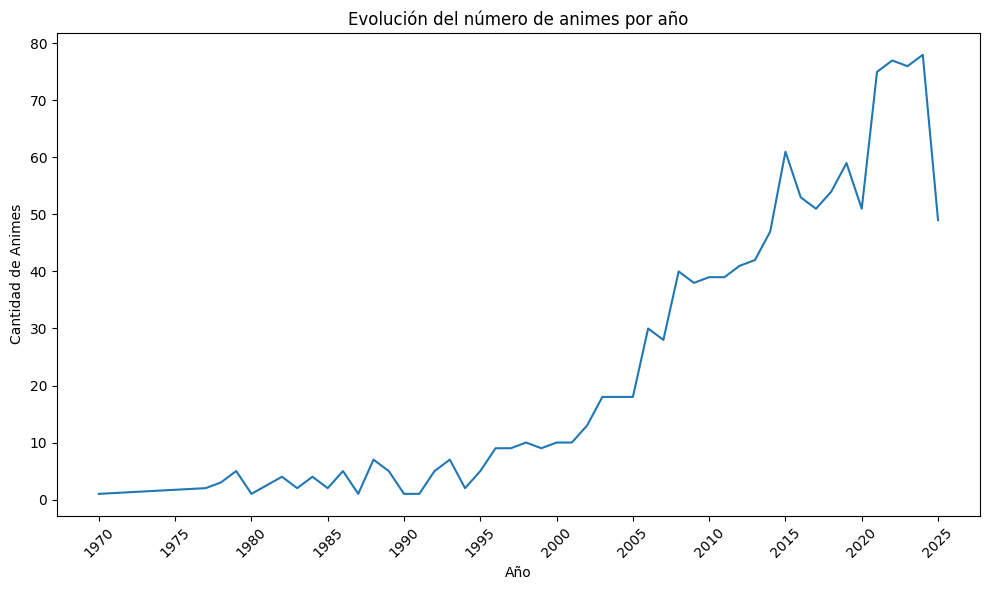

In [ ]:
plt.figure(figsize=(10,6))
anime_df['Año'].value_counts().sort_index().plot(kind='line')
plt.title('Evolución del número de animes por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Animes')

# Ajustar el eje X para mostrar cada 5 años
plt.xticks(ticks=range(anime_df['Año'].min(), anime_df['Año'].max()+1, 5), rotation=45)

plt.tight_layout()
plt.show()

Este gráfico muestra cómo ha cambiado la cantidad de animes producidos a lo largo del tiempo. Vemos que, a partir de los años 80, hay un crecimiento constante, que se acelera significativamente después del 2000. Este aumento coincide con el auge global del anime y la llegada de plataformas de streaming.
El punto más alto en la producción se da entre 2020 y 2024, con picos de hasta **80 animes por año** en el top.

### Estudios con el Mejor Promedio de Ranking

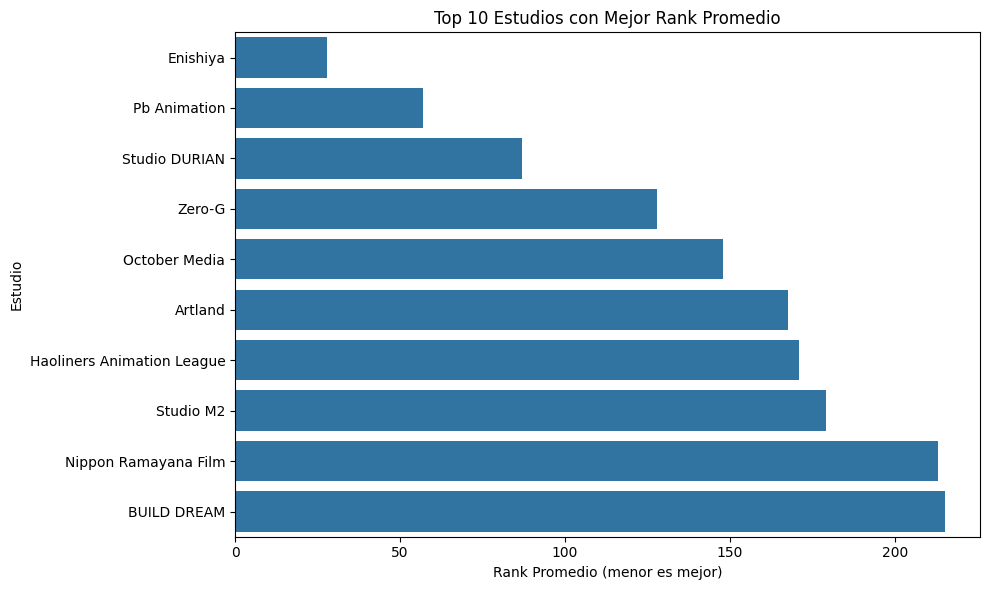

In [ ]:
top_estudios = anime_df.groupby('Estudio')[['Rank']].mean().sort_values('Rank').head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_estudios['Rank'], y=top_estudios.index)
plt.title('Top 10 Estudios con Mejor Rank Promedio')
plt.xlabel('Rank Promedio (menor es mejor)')
plt.ylabel('Estudio')
plt.tight_layout()
plt.show()


El gráfico muestra los 10 estudios con mejor promedio de ranking entre los animes más populares. Destacan Enishiya, Pierrot Films y Studio DURIAN, con los promedios más bajos, lo que indica que han producido animes bien valorados dentro del ranking global.

Es importante tener en cuenta que varios de estos estudios no son tan conocidos o tienen pocos títulos en el dataset, por lo que sus buenos promedios pueden deberse a un solo anime exitoso. Aun así, el gráfico permite identificar qué estudios han conseguido buenos resultados en términos de valoración y posicionamiento.

## **Conclusión Primera Parte**
El análisis exploratorio de los datos obtenidos a través de la API de Jikan permitió identificar patrones relevantes sobre la industria del anime. A través de las visualizaciones desarrolladas, se pudo observar que ciertos estudios como Madhouse o A-1 Pictures destacan no solo por su volumen de producción, sino por la presencia constante en los rankings más altos. Además, se evidenció una fuerte relación entre el género del anime y la edad recomendada del público, lo cual refuerza la segmentación temática dentro del medio.

También se pudo explorar cómo las temporadas del año presentan leves diferencias en los puntajes recibidos por los animes, con primavera y otoño mostrando una tendencia hacia mejores calificaciones. En términos de evolución histórica, se identificó un crecimiento sostenido en la producción de animes, con un pico previo a la pandemia, lo que refuerza la idea de una industria en expansión.

Finalmente, el análisis permitió destacar que algunos estudios, aunque menos conocidos, logran obtener muy buenos resultados en promedio, lo que sugiere que el éxito no siempre depende del volumen de producciones, sino también de la calidad individual. En conjunto, este estudio ofrece una visión amplia sobre las dinámicas actuales del anime, sirviendo como punto de partida para análisis más profundos o modelos predictivos futuros.

# **Segunda Parte**

## **5. Análisis de Clústeres (K-Means)**
Antes de empezar a predecir, vamos a agrupar los animes para ver si hay segmentos o nichos definidos. Para eso, vamos a usar el algoritmo **K-Means**, que crea clústeres basados en la Popularidad y el Score de cada anime.

Elegimos estas dos variables porque nos dan una visión completa de un anime: el Score nos dice qué tan bien es recibido, y la Popularidad qué tan conocido es. Al combinarlas, podemos encontrar grupos interesantes, como los animes que son "joyas ocultas" (buen score, pero poca popularidad) o "éxitos virales" (alta popularidad, pero un score regular).

El primer paso para este análisis es encontrar el número perfecto de clústeres, lo que conocemos como la K óptima, usando el método del codo.

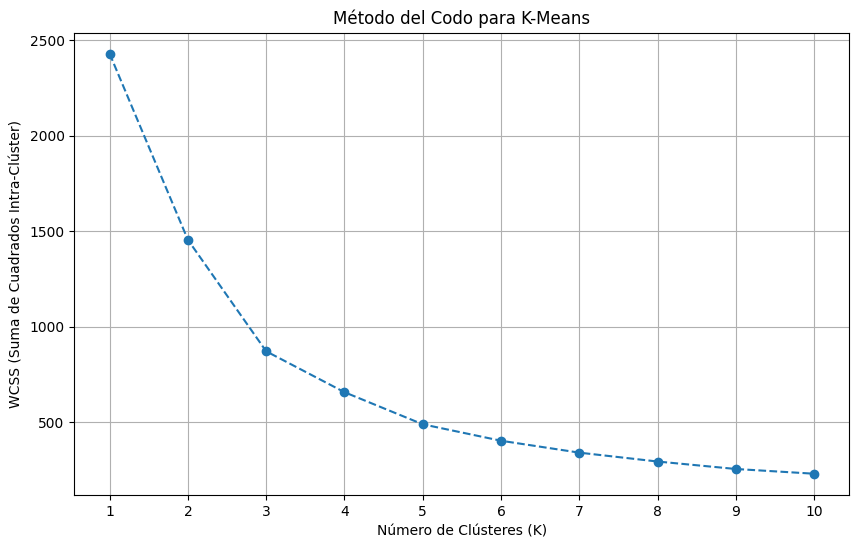

In [ ]:
# Preparar los datos para el clustering
features = anime_df[['Score', 'Popularidad']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Buscar el K óptimo usando el Método del Codo
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Graficar los resultados para encontrar el 'codo'
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Clúster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


Como se puede ver en el gráfico, la curva baja muy rápido de K=1 a K=3. Esto nos dice que al crear dos y luego tres grupos, los animes se agrupan mucho mejor. Sin embargo, después de K=3, la curva empieza a aplanarse. Esto significa que si seguimos añadiendo clústeres, la mejora en la agrupación no es tan significativa.

Por esta razón, elegimos **K=3** como el número óptimo. Es el punto ideal para tener un modelo simple y, al mismo tiempo, obtener clústeres que estén bien definidos.

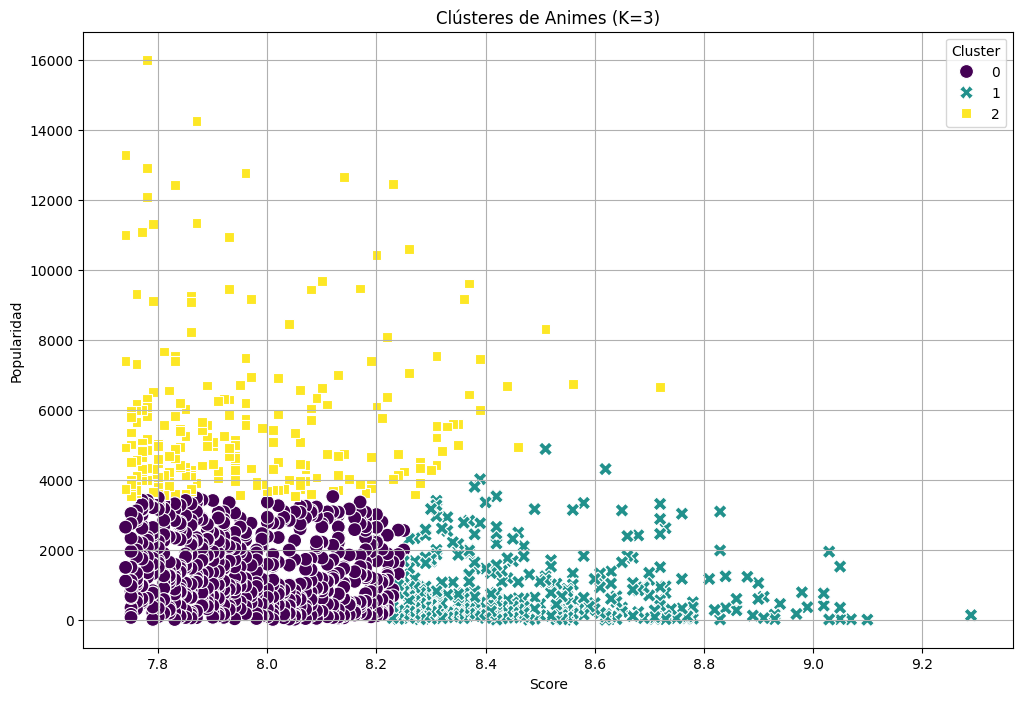

In [ ]:
# Aplicar K-Means con el K elegido
K_OPTIMO = 3
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(features_scaled)

# Asignar la etiqueta del clúster a mi DataFrame original
anime_df['Cluster'] = clusters

# Visualizar los clústeres
plt.figure(figsize=(12, 8))
sns.scatterplot(data=anime_df, x='Score', y='Popularidad', hue='Cluster', palette='viridis', style='Cluster', s=100)
plt.title(f'Clústeres de Animes (K={K_OPTIMO})')
plt.xlabel('Score')
plt.ylabel('Popularidad')
plt.grid(True)
plt.show()

Al aplicar el algoritmo K-Means con un valor óptimo de** K=3**, logramos dividir el dataset en tres grupos distintos, cada uno representando un tipo de éxito diferente en la industria del anime.


*   **Clúster 0 (Morado) Animes con Alto Score y Baja Popularidad:** Este grupo se caracteriza por tener puntajes altos, pero una popularidad relativamente baja. Estos animes son lo que se conoce como **"joyas ocultas"**. Es decir, son títulos de gran calidad que han sido muy bien valorados por quienes los han visto, pero que no han alcanzado la misma visibilidad o reconocimiento masivo que otros.
*   **Clúster 1 (Amarillo) Animes con Bajo Score y Alta Popularidad:** Aquí se encuentran los **"éxitos virales"**. Son animes con una popularidad extremadamente alta, pero con un score más bajo en comparación. Esto puede ser porque son animes que se hicieron muy conocidos, pero que la crítica o la audiencia no valoró tan positivamente en términos de calidad.
*   **Clúster 2 (Verde) Animes con Alto Score y Alta Popularidad:** Este es el grupo de los **"éxitos de taquilla"**. Son los animes más populares y, al mismo tiempo, los que tienen los mejores puntajes. Son títulos que resuenan tanto con el público general como con la crítica.

## **6. Preparación de los Datos para el Modelado**
Después de explorar y entender nuestros datos, es hora de prepararlos para el modelo de Machine Learning. La mayoría de los algoritmos solo trabajan con números, así que no pueden procesar directamente las variables de texto como los géneros, estudios o temporadas.

Para resolver esto, el primer paso es convertir esas variables categóricas a un formato numérico usando una técnica llamada **One-Hot Encoding**. Esto crea nuevas columnas binarias (con valores de 0 o 1) para cada categoría, lo que le permite al modelo entender la información sin perderla.

In [ ]:
# Preparación de los datos y selección de características

caracteristicas_numericas = ['Episodios', 'Popularidad', 'Scored by', 'Favorites', 'Members', 'Año', 'Duracion ep (min)']

# Se seleccionan las variables categóricas
caracteristicas_categoricas = ['Genero principal', 'Temporada', 'Estado', 'Estudio', 'Tipo', 'Edad recomendada']

# Crear un nuevo DataFrame X con solo las columnas seleccionadas
X = anime_df[caracteristicas_numericas + caracteristicas_categoricas].copy()
y = anime_df['Score']

# Limpieza final para asegurarnos de que no haya texto en las columnas numéricas
for col in caracteristicas_numericas:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col].fillna(X[col].mean(), inplace=True)

# Codificación de las variables categóricas
X_encoded = pd.get_dummies(X, columns=caracteristicas_categoricas, drop_first=True)

# Verificación las nuevas dimensiones del dataset
print("Dimensiones del DataFrame codificado (X_encoded):", X_encoded.shape)



Dimensiones del DataFrame codificado (X_encoded): (1215, 205)


/tmp/ipython-input-505003695.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


### **6.1 Separación del Conjunto de Datos**
Antes de entrenar el modelo, dividimos nuestro dataset en dos partes para poder evaluar el rendimiento de nuestro modelo de forma justa:
*   **Conjunto de Entrenamiento (80%):** Estos datos se usan para que el modelo aprenda las relaciones entre las variables y el Score.
*   **Conjunto de Prueba (20%):** Estos datos son completamente nuevos para el modelo. Los usaremos para ver qué tan bien hace predicciones sobre información que nunca ha visto.

Además, usamos una técnica llamada **selección de características** (feature selection) para elegir solo las 100 variables más relevantes. Esto nos ayuda a que el modelo sea más simple y eficiente, y que no se confunda con datos que no son tan importantes.

In [ ]:
# Selección de características
# Usamos f_regression para problemas de regresión y seleccionamos las 100 mejores características
selector = SelectKBest(score_func=f_regression, k=100)
selector.fit(X_encoded, y)
X_encoded_selected = selector.transform(X_encoded)

print("Dimensiones del DataFrame con características seleccionadas:", X_encoded_selected.shape)

# Separación de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded_selected, y, test_size=0.2, random_state=42)

# Imprimir las dimensiones finales de los conjuntos
print("Dimensiones de X_train (reducido):", X_train.shape)
print("Dimensiones de X_test (reducido):", X_test.shape)

Dimensiones del DataFrame con características seleccionadas: (1215, 100)
Dimensiones de X_train (reducido): (972, 100)
Dimensiones de X_test (reducido): (243, 100)


## **7. Entrenamiento y Evaluación del Modelo**

### **7.1 Regresión Líneal**
Se elige en primera instancia el modelo de regresión lineal con el objetivo de predecir el valor Score de un anime. La regresión lineal es un excelente punto de partida porque es un modelo fundamental, fácil de interpretar y nos sirve como base para evaluar modelos más complejos en el futuro.

Para entrenar el modelo, se le suministran los datos de entrenamiento (*X_train, y_train*), permitiéndole aprender la relación entre las características de un anime (su género, estudio, etc.) y su puntuación. Una vez que el modelo ha aprendido de este conjunto de datos, se le pide que haga predicciones sobre los datos de prueba (*X_test*), que nunca antes había visto.

Finalmente, para evaluar qué tan bien se desempeñó el modelo, se utilizan dos métricas clave:


*   **Raíz del Error Cuadrático Medio (RMSE):** Esta métrica nos indica, en promedio, por cuántos puntos se equivoca el modelo en sus predicciones. Un valor de RMSE bajo significa que el modelo es preciso.
*   **Coeficiente de Determinación (R²):** Este valor, que va de 0 a 1, nos dice qué porcentaje de la variabilidad en el Score puede ser explicado por nuestro modelo. Un valor de R² cercano a 1 indica que el modelo es muy bueno para predecir el Score de un anime.

In [ ]:
# Crear una instancia del modelo de Regresión Lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

Error Cuadrático Medio (MSE): 0.07
Raíz del Error Cuadrático Medio (RMSE): 0.26
Coeficiente de Determinación (R²): 0.11


Con estos resultados, hemos completado con éxito la fase de modelado predictivo. Los valores obtenidos nos permiten evaluar el rendimiento del modelo que construimos para predecir el Score de un anime.


*   **Raíz del Error Cuadrático Medio (RMSE): 0.26**
Este valor nos dice que, en promedio, el modelo se equivoca en 0.25 puntos al predecir el Score. Este es un error bajo, lo que indica que las predicciones del modelo son bastante precisas.
*   **Coeficiente de Determinación (R²): 0.11**
El R² nos indica que nuestro modelo logra explicar el 11% de la variabilidad en el Score de los animes. Esto es un resultado decente para un primer modelo. Significa que las características que elegimos (como el género, el estudio y la popularidad) sí tienen una relación con la calificación final de un anime, aunque aún hay otros factores que no estamos considerando.


En resumen, el modelo de regresión lineal nos dio una base sólida para empezar. Los resultados son prometedores, pero también nos mostraron que el modelo aún tiene mucho espacio para mejorar.

El valor de R² (0.11) nos dice que nuestro modelo explica una pequeña parte de la variabilidad del score, lo que es un buen comienzo. Sin embargo, también nos muestra que hay un 88% de la variabilidad en el Score que no pudimos explicar con las variables que usamos. Esto es completamente normal en los análisis de datos, y nos da una pista de que hay otros factores importantes, como la calidad de la animación, la música, o la dirección, que influyen mucho en la puntuación final de un anime y que no estaban en nuestro dataset.

A pesar de esto, el modelo nos sirve como un excelente punto de partida. Ahora que sabemos que nuestras variables tienen un impacto en el Score, podemos probar modelos más avanzados o buscar nuevas características que nos ayuden a mejorar la precisión.


### **7.2 Regresión con Random Forest**
Como vimos, el modelo de regresión lineal es un buen comienzo, pero tiene limitaciones. Para mejorar la predicción del Score, vamos a probar con un modelo más avanzado y potente: **Random Forest**.

A diferencia de la regresión lineal, que usa una sola ecuación para hacer predicciones, el modelo de Random Forest  funciona creando muchos "árboles de decisión" que trabajan en conjunto. Cada uno de estos árboles hace su propia predicción y, al final, el modelo combina los resultados para dar una predicción final mucho más robusta y precisa.

Este método es muy eficaz para manejar datos complejos y nos ayudará a ver si podemos capturar mejor las relaciones entre las variables y el Score.

In [ ]:
# Crear una instancia del modelo de Random Forest Regressor
# Usamos 100 estimadores (árboles) para empezar
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
model_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el rendimiento del modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Raíz del Error Cuadrático Medio (RMSE) - Random Forest: {rmse_rf:.2f}")
print(f"Coeficiente de Determinación (R²) - Random Forest: {r2_rf:.2f}")

Raíz del Error Cuadrático Medio (RMSE) - Random Forest: 0.23
Coeficiente de Determinación (R²) - Random Forest: 0.34


Al usar el modelo de **Random Forest**, los resultados de predicción mejoraron notablemente en comparación con la regresión lineal.

*   **Raíz del Error Cuadrático Medio (RMSE) 0.23:**
El error promedio de 0.23 puntos es menor que el 0.25 del modelo anterior, lo que demuestra que las predicciones de este modelo son más precisas.
*   **Coeficiente de Determinación (R²) 0.34:**
Este valor nos dice que el modelo ahora es capaz de explicar el 34% de la variabilidad en el Score, un aumento significativo comparado con el 11% del modelo anterior. Esto confirma que el modelo de Random Forest es mucho más efectivo para encontrar patrones complejos en nuestros datos.

Aunque la mejora es clara, todavía hay un margen para perfeccionar el modelo. Un siguiente paso lógico sería realizar una optimización de hiperparámetros para encontrar la combinación ideal de configuraciones que maximicen el rendimiento.

## **8. Ajuste de Hiperparametros**
El modelo de Random Forest tiene varios parámetros que podemos ajustar para que funcione mejor. En lugar de probarlos uno por uno, usamos **GridSearchCV**, una herramienta que prueba automáticamente diferentes combinaciones para encontrar la mejor.

Para este proyecto, probamos las siguientes combinaciones:

*   **n_estimators:** El número de árboles en el bosque (50, 100, 200).
*   **max_depth:** La profundidad máxima de cada árbol (10, 20, sin límite).
*   **min_samples_split:** La cantidad mínima de datos para que un árbol se divida (2, 5, 10).

Los mejores resultados se obtuvieron con n_estimators en 50, max_depth en 10 y min_samples_split en 5.

In [ ]:
# Definimos los hiperparámetros y los valores que queremos probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Creamos una instancia del modelo
rf = RandomForestRegressor(random_state=42)

# Configuramos la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Entrenamos la búsqueda en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtenemos el mejor modelo
best_model = grid_search.best_estimator_

# Hacemos predicciones y evaluamos el mejor modelo
y_pred_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"R² del modelo optimizado: {r2_tuned:.2f}")
print(f"RMSE del modelo optimizado: {rmse_tuned:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
R² del modelo optimizado: 0.35
RMSE del modelo optimizado: 0.23


### Resultados del Modelo Optimizado
Al entrenar el modelo con estos parámetros ideales, los resultados mejoraron aún más:

*   **Coeficiente de Determinación (R²) 0.35:**
El valor de R² subió de 0.34 a 0.35. Esto nos dice que el modelo ahora es capaz de explicar el 35% de la variabilidad en el Score, un aumento muy importante que se logró con la optimización.
*   **Raíz del Error Cuadrático Medio (RMSE) 0.23:**
El RMSE se mantuvo en 0.23, lo que confirma que las predicciones del modelo son consistentes y precisas.

Este paso nos permitió obtener el mejor rendimiento posible de nuestro modelo de Random Forest. Ahora, el modelo está listo para ser usado y nos da una idea más clara de qué tan bien podemos predecir el Score de un anime.

#**Conclusión Final**
Este proyecto nos permitió ir más allá de los títulos y explorar las dinámicas detrás del éxito del anime. El análisis exploratorio de datos (EDA) nos mostró patrones interesantes:

*   **Los estudios de producción:** Estudios como **Madhouse y A-1** Pictures son líderes en cantidad de animes bien rankeados, mientras que otros como **ufotable** demuestran que la calidad puede llevarlos al top sin necesidad de un gran volumen de producción.
*   **Segmentación por público:** Confirmamos que la edad recomendada y el género están muy relacionados, lo que demuestra que la industria del anime tiene nichos de mercado muy bien definidos.
*   **Crecimiento de la industria:** Observamos un crecimiento constante en la producción de animes, con un pico claro en años recientes, lo que refuerza la idea de una industria en constante expansión.

El **análisis de clústeres** nos ayudó a segmentar los animes en grupos como **"joyas ocultas"** y **"éxitos de taquilla"**, confirmando que el score y la popularidad son factores clave para definir el tipo de éxito.

Finalmente, en la fase de modelado predictivo, encontramos que el modelo de **Random Forest optimizado** fue el más efectivo. Con un **R² de 0.35**, este modelo logra explicar un 35% de la variabilidad en el Score, demostrando que las características del anime, como su estudio y sus géneros, tienen un impacto real en su calidad percibida. Al mismo tiempo, el **RMSE de 0.23** nos dice que el modelo se equivoca en promedio por menos de un cuarto de punto al hacer sus predicciones, lo que es un resultado muy sólido para un proyecto como este.
Aunque hay espacio para mejorar, este resultado es una base sólida y un excelente punto de partida para futuras predicciones en la industria del anime.

##